# Implementación de Modelos de Riesgo

Este conjunto de códigos ejecuta una implementación ejemplo de un conjunto de modelos de riesgo aplicados a los datos de muestra provistos por Integra, datosdeduda.xlsx, a partir de su base de datos principal. La implementación consta de tres secciones: (i) un modelo de propabilidad de default simple como línea base, (ii) un modelo de probabilidad de default utilizando algoritmos de reducción de dimensionalidad; y, (iii) un modelo de probabilidad de default utilizando algortimos de aprendizaje automático. Los resultados permiten obtener un score de probabilidad de default inicial para valorar la calidad de los deudores y enfocar los esfuerzos de cobro en aquellos donde serán más efectivos. 

Debido a que la información proporcionada es una muestra acotada de los datos originales y, a su vez, contiene una limitada selección de variables y características, la implementación y los modelos presentados a continuación podría considerarse como una versión beta reducida de los modelos descritos en la propuesta metodológica, PropuestaMetodologica_LM061021.docx. En el caso de una implementación *en vivo* en el sistema de información de Integra, es importante revisar y actualizar los supuestos sobre los datos y sobre el sistema de procesamiento de información que el código presentado a continuación.

## Librerias y requerimientos

In [2]:
import pandas as pd
import numpy as np
import sklearn
from datetime import datetime
from datetime import date
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Obtención de Datos

Los datos fueron proporcionados en un archivo de Excel, por lo que se importan directamente a través de un proceso local.

In [3]:
df_raw = pd.read_excel('datosdeuda.xlsx')

In [4]:
df_raw

,Interlocutor,Cuenta,Objeto,Ejercicio_Emision_Cobro,Periodo_Emision_Cobro,Meses_Pago,Dias_Pago,Periodo_Inicio,Periodo_Finalizacion,Ejercicio_Deuda,...,Tipo_de_Declaracion,Anio_Ultima_Declaracion,Actividad_Economica,Total_Activo,Activo_Sujeto_de_Impuesto,Impuesto_Computado_Municipal,Total_Ingresos_Brutos,Fecha_Primera_Gestion_Cobro,Fecha_Ultima_Gestion_Cobro,Vias_de_Gestion_Cobro
0,1500160088,1010067397,10110108991,2018,11,0.0,19.0,20181101,20181130,2018,...,F2,NaN,171.0,NaN,NaN,NaN,NaN,2019-09-04,2019-09-26,Call Center
1,1500160088,1010067397,10110108991,2019,5,1.0,43.0,20190501,20190531,2019,...,F2,NaN,171.0,NaN,NaN,NaN,NaN,2019-09-04,2019-09-26,Call Center
2,1500160088,1010067397,10110108991,2018,5,0.0,17.0,20180501,20180531,2018,...,F2,NaN,171.0,NaN,NaN,NaN,NaN,2019-09-04,2019-09-26,Call Center
3,1500160088,1010067397,10110108991,2020,1,0.0,14.0,20200101,20200131,2020,...,F2,NaN,171.0,NaN,NaN,NaN,NaN,2019-09-04,2019-09-26,Call Center
4,1500160088,1010067397,10110108991,2017,12,0.0,18.0,20171201,20171231,2017,...,F2,NaN,171.0,NaN,NaN,NaN,NaN,2019-09-04,2019-09-26,Call Center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1500167531,1010045855,10110102242,2021,7,0.0,28.0,20210701,20210731,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
996,1500179744,1010090197,10110092338,2019,10,NaN,NaN,20191001,20191031,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
997,1500179744,1010090197,10110092338,2020,3,NaN,NaN,20200301,20200331,2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
998,1500179744,1010090197,10110092338,2016,8,40.0,1247.0,20160901,20160930,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


# Estimación de un Modelo de Probabilidad de Default

## Identificación de variables y elementos esenciales

De acuerdo a la metodología propuesta, el primer paso para la implementación del modelo de probabilidad de default es la identificación del evento de default y la unidad de análisis. Considerando la estructura de datos expuesta por el equipo de integra, se asume que la variable **Interlocutor** ejerce el rol de contribuyente o deudor, la variable **Cuenta** funge como cuenta tributaria, y la variable **Objeto** identifican al hecho generador.

In [5]:
table = np.round(pd.pivot_table(df_raw, values=['Cuenta', 'Objeto'], 
                                index=['Interlocutor'], 
                                aggfunc=lambda x: len(x.unique()),
                                fill_value=0),2)
table['diff'] = table['Cuenta'] - table['Objeto']
table['diff'].value_counts()

 0     191
-1       4
-3       2
-13      1
-2       1
Name: diff, dtype: int64

No obstante, la revisión de los datos provistos muestra que las variables **Cuenta** y **Objeto** existen en la misma dimensionalidad para cada Interlocutor, por lo que se toma como unidad de análisis la variable **Objeto** ya que tiene la mayor cantidad de valores únicos. A nivel de agregación transaccional se presume la existencia de efectos de clúster y agregación a nivel de interlocutor y de Cuenta.

Por otra parte, en cuanto a la definición de default, este análisis parte de una propuesta más simple con respecto a la que se presento en la metodología por múltiples razones. Primero, porque no se considera el aspecto de extinción del hecho generador;segundo, ya que no existe claridad sobre si las variables de monto de deuda con las que se cuenta representan un stock o un flujo; tercero, debido a que existen inconsistencias temporales en los datos pues existen periodos vacios para algunas cuentas e interlocutres y no se tiene información sobre la naturaleza de esos vacíos; finalmente, dada la existencia de pagos parciales requiere de una definición de default más amplia y flexible.

En consecuencia, se asume:
- Que la variable **Monto_Deuda** es de tipo stock dentro del mismo periodo, pero de tipo flujo entre distintos periodos de tiempo, con base en la variable **Periodo_Finalización**
- Que la variable **Monto_Pago** es de tipo flujo, por lo que se calcularán los valores acumulados y los vencimientos respectivos, para aquellos pagos fragmentados en múltiples filas de datos.
- Que la situación de default ocurre cuando no se registra ningún pago por la deuda asociada a una cuenta; o la suma de los pagos registrados por cuenta específica no extinguen por completo la deuda, o la deuda se extingue después de 90 días luego del vencimiento.

Adicionalmente, se presentan otras definiciones de default como variables auxiliares; no obstante, el análisis principal gira en torno a la definición anterior.

## Preparación de datos

In [6]:
# Renombramiento y reordenamiento de variables

## Nuevas nombres de variables
df1 = df_raw.rename({'Periodo_Inicio': 'emision', 'Periodo_Finalizacion': 'vencimiento', 'Monto_Deuda': 'deudaf', 
                     'Monto_Pago': 'pago', 'Fecha_Pago': 'liquidacion', 'Distrito_Inmueble': 'distrito', 
                     'Ejercicio_Emision_Cobro': 'year', 'Periodo_Emision_Cobro': 'mes'}, axis=1) 
df1 = df1.sort_values(['Interlocutor', 'Objeto', 'vencimiento', 'liquidacion', ])
## Variables de fecha
df1['vencimiento'] = pd.to_datetime(df1['vencimiento'], format='%Y%m%d', errors='coerce')
df1['liquidacion'] = pd.to_datetime(df1['liquidacion'], format='%Y%m%d', errors='coerce')
df1['emision'] = pd.to_datetime(df1['emision'], format='%Y%m%d', errors='coerce')
df1['date'] = date.today()
df1['date'] = pd.to_datetime(df1['date'])
df1.loc[(df1['Estado'] == "SIN PAGO") & (df1['liquidacion'].isnull() == False), 'liquidacion'] = np.nan
## Reordernar columnas para facilidad de lectura de datos
cols = list(df1.columns)
a, b, c, d = cols.index('vencimiento'), cols.index('Objeto'), cols.index('liquidacion'), cols.index('year')
cols[a], cols[b], cols[c], cols[d] = cols[b], cols[a], cols[d], cols[c]
df1 = df1[cols]
a, b, c, d = cols.index('deudaf'), cols.index('mes'), cols.index('pago'), cols.index('Meses_Pago')
cols[a], cols[b], cols[c], cols[d] = cols[b], cols[a], cols[d], cols[c]
df1 = df1[cols]


#### Variables asociadas al inmueble

## Imputación de tamaño a edificio con nivel 3 pero missing en nivel 2 y 1
df1.loc[df1['Mts2_Inmueble_Nivel_3']>0, 'Mts2_Inmueble_Nivel_2'] = df1['Mts2_Inmueble_Nivel_3']
df1.loc[df1['Mts2_Inmueble_Nivel_3']>0, 'Mts2_Inmueble_Nivel_1'] = df1['Mts2_Inmueble_Nivel_3']
## Número de niveles
df1['levels'] = df1[['Mts2_Inmueble_Nivel_1', 'Mts2_Inmueble_Nivel_2', 'Mts2_Inmueble_Nivel_3', 'Mts2_Inmueble_Nivel_4', 
                   'Mts2_Inmueble_Nivel_5', 'Mts2_Inmueble_Nivel_6', 'Mts2_Inmueble_Nivel_7', 'Mts2_Inmueble_Nivel_8', 
                   'Mts2_Inmueble_Nivel_9', 'Mts2_Inmueble_Nivel_10']].count(axis=1)
## Renombramiento de variables
df1['nivel1'] = df1['Mts2_Inmueble_Nivel_1']
df1['nivel2'] = df1['Mts2_Inmueble_Nivel_2']
df1['nivel3'] = df1['Mts2_Inmueble_Nivel_3']
## Imputación a cero para missing values en variables relacionadas al inmueble
for x in df1.filter(regex='^nivel',axis=1).columns: df1.loc[df1[x].isnull(), x] = 0
for x in df1.filter(regex='^Mts2_Area_',axis=1).columns: df1.loc[df1[x].isnull(), x] = 0
## Area promedio por nivel inmueble
df1['sizelv_sum'] = df1['nivel1'] + df1['nivel2'] + df1['nivel3']
df1['sizelv_mean'] = df1['sizelv_sum'] / df1['levels']
df1.loc[df1['sizelv_mean'].isnull(), 'sizelv_mean'] = 0


#### Creación de variables relevantes

## Suma de los pagos a una misma deuda
df1["pagosct_sum"] = df1.groupby(['Interlocutor', 'Objeto', 'vencimiento'])['pago'].transform(sum)
## Número de pagos efectuados a una misma deuda
df1["pagosct_n"] = df1.groupby(['Interlocutor', 'Objeto', 'vencimiento'])['pago'].transform('count')
df1.loc[df1['Estado'] == "SIN PAGO", 'pagosct_n'] = 0
## Valor promedio de los pagos efectuados a una misma deuda
df1["pagosct_mean"] = df1.groupby(['Interlocutor', 'Objeto', 'vencimiento'])['pago'].transform('mean')
## Valor promedio de los pagos efectuados a una misma objeto
df1["pagosc_mean"] = df1.groupby(['Interlocutor', 'Objeto'])['pagosct_mean'].transform('mean')
## Total de días de vencimiento de la deuda al momento del pago
df1['dias_vencido'] = (df1['liquidacion'] - df1['vencimiento']).dt.days
df1.loc[df1['dias_vencido'] < 0, 'dias_vencido'] = 0
df1.loc[df1['dias_vencido'].isnull(), 'dias_vencido'] = (df1['date'] - df1['vencimiento']).dt.days
## Tiempo hasta el pago i de una misma deuda
df1['tpagoi_ct'] = df1.groupby(['Interlocutor', 'Objeto', 'vencimiento'])['liquidacion'].diff().dt.days
df1.loc[df1['pagosct_n'] == 1, 'tpagoi_ct'] = df1['dias_vencido']
df1.loc[(df1['pagosct_n'] > 1) & (df1['tpagoi_ct'].isnull()), 'tpagoi_ct'] = df1['dias_vencido']
df1.loc[(df1['tpagoi_ct'].isnull()), 'tpagoi_ct'] = df1['dias_vencido']
## Tiempo entre pagos de una misma deuda 
df1['epagos_ct'] = df1.groupby(['Interlocutor', 'Objeto', 'vencimiento'])['liquidacion'].diff().dt.days
df1.loc[(df1['pagosct_n'] > 1) & (df1['epagos_ct'].isnull()), 'epagos_ct'] = 0
## Tiempo promedio entre pagos a una misma deuda
df1["tpagoi_ct_mean"] = df1.groupby(['Interlocutor', 'Objeto', 'vencimiento'])['tpagoi_ct'].transform('mean')
## Tiempo promedio entre pagos a un mismo objeto
df1["tpagoc_mean"] = df1.groupby(['Interlocutor', 'Objeto'])['tpagoi_ct_mean'].transform('mean')
## Pagos acumulados de una misma deuda
df1["pagosct_csum"] = df1.groupby(['Interlocutor', 'Objeto', 'vencimiento'])['pago'].transform('cumsum')
## Pagos acumulados de un mismo objeto
df1["pagosct_csum"] = df1.groupby(['Interlocutor', 'Objeto', 'vencimiento'])['pago'].transform('cumsum')
## Saldo de la deuda después de cada pago
df1['deudas'] = df1['deudaf'] - df1['pagosct_csum']
## Porcentaje de deuda liquidado
df1['liquid_ct'] = df1['pagosct_csum']/df1['deudaf']
## Default
df1['default_90'] = np.where( ( df1['pagosct_sum'] == 0 ) | (df1['pagosct_sum'] < df1['deudaf']) | ( (df1['pagosct_sum'] >= df1['deudaf']) & (df1['dias_vencido'] > 90 )), 1, 0)
df1['default_180'] = np.where( ( df1['pagosct_sum'] == 0 ) | (df1['pagosct_sum'] < df1['deudaf']) | ( (df1['pagosct_sum'] >= df1['deudaf']) & (df1['dias_vencido'] > 180 )), 1, 0)
df1['default_inf'] = np.where( ( df1['pagosct_sum'] == 0 ) | (df1['pagosct_sum'] < df1['deudaf']), 1, 0)


#### Dataset con datos por transaccion

## Creación de nuevas caracteristicas sobre datos agregados
df2 = df1
df2.drop_duplicates(subset=['Interlocutor', 'Objeto', 'vencimiento'], keep='last', inplace=True)
## Valor total de la deuda acumulada por objeto
df2["pagosc_csum"] = df2.groupby(['Interlocutor', 'Objeto'])['pagosct_sum'].transform('cumsum')
## Valor total de los pagos acumulados por objeto
df2["deudac_csum"] = df2.groupby(['Interlocutor', 'Objeto'])['deudaf'].transform('cumsum')
## Saldo final acumulado por objeto
df2['saldof'] = df2['deudac_csum'] - df2['pagosc_csum']
## Saldo inicial acumulado por objeto
df2['saldoi'] = df2.groupby(['Interlocutor', 'Objeto'])['saldof'].shift()
df2.loc[df2['saldoi'].isnull(), 'saldoi'] = 0
## Valor promedio de la deuda generada por un mismo objeto
df2["deudaf_mean"] = df2.groupby(['Interlocutor', 'Objeto'])['deudaf'].transform('mean')
## Valor promedio de los días de vencimiento generados por un mismo objeto
df2["diasven_mean"] = df2.groupby(['Interlocutor', 'Objeto'])['dias_vencido'].transform('mean')
## Porcentaje de deuda liquidado
df2['liquid_c'] = df2['pagosc_csum'] / df2["deudac_csum"]
## Vigencia de la deuda
df2['vigente'] = np.where( ( df2['pagosct_sum'] < df2['deudaf'] ), 1, 0)
## Algún esfuerzo de cobro
df2['cobro'] = np.where( (df2['Fecha_Primera_Gestion_Cobro'].isnull() == False), 1, 0)
df2.loc[ (df2['Fecha_Primera_Gestion_Cobro'] > df2['liquidacion']) & (df2['liquid_ct'] == 1), 'cobro'] = 0
## Exposición a cobros
df2['cobro_exp'] = df2['Fecha_Ultima_Gestion_Cobro'] -df2['Fecha_Primera_Gestion_Cobro']
df2.loc[df2['cobro'] == 0 , 'corbo_exp'] = 0
df2.loc[df2['cobro_exp'].isnull() , 'cobro_exp'] = 0
for index in df2.index:
    try:
        df2.loc[index,'cobro_exp'] = df2.loc[index,'cobro_exp'].days
    except:
        pass    
## Esfuerzos de cobros a los que estuvo sometido - Call Center
df2['cobro_CC'] = np.where(df2['Vias_de_Gestion_Cobro'].str.contains("call center", case=False, na=False), 1, 0)
df2.loc[df2['cobro'] == 0 , 'cobro_CC'] = 0
## Esfuerzos de cobros a los que estuvo sometido - Mensajeria
df2['cobro_M'] = np.where(df2['Vias_de_Gestion_Cobro'].str.contains("mensajeria", case=False, na=False), 1, 0)
df2.loc[df2['cobro'] == 0 , 'cobro_M'] = 0
## Esfuerzos de cobros a los que estuvo sometido - Cobro Externo
df2['cobro_CE'] = np.where(df2['Vias_de_Gestion_Cobro'].str.contains("cobro externo", case=False, na=False), 1, 0)
df2.loc[df2['cobro'] == 0 , 'cobro_CE'] = 0
## Rezago de días vencidos con valor cero en el primer pago
df2['dias_vencido_l1'] = df2.groupby(['Interlocutor', 'Objeto'])['dias_vencido'].shift()
df2.loc[df2['dias_vencido_l1'].isnull(), 'dias_vencido_l1'] = 0
## Rezago de pagos acumulados en un mismo objeto
df2['pagosc_csum_l1'] = df2.groupby(['Interlocutor', 'Objeto'])['pagosc_csum'].shift()
df2.loc[df2['pagosc_csum_l1'].isnull(), 'pagosc_csum_l1'] = 0
## Rezago de pagos acumulados en un mismo objeto
df2['liquid_c_l1'] = df2.groupby(['Interlocutor', 'Objeto'])['liquid_c'].shift()
df2.loc[df2['liquid_c_l1'].isnull(), 'liquid_c_l1'] = 0


#### PCA para reducir dimensionalidad de variables descriptoras del inmueble

## Obtener Componentes Principales
H = df2[['Mts2_Area_Arborizada', 'Mts2_Area_Boscosa', 'Mts2_Area_Por_Sanemiento','Mts2_Area_Estacionamiento', 
                'Mts2_Area_Comun', 'Mts2_Area_Bodega', 'Mts2_Area_Subterranea', 'nivel1', 'nivel2', 'nivel3']]
scaler = MinMaxScaler()
Hrs = scaler.fit_transform(H)
pca = PCA(n_components = 0.95)
pca.fit(Hrs)
Hr = pca.transform(Hrs)
components = ['pca_{}'.format(i) for i in range(len(Hr[0]))]
Hr = pd.DataFrame(Hr, columns=components)
## Reiniciar Indice en datos originales y concatenar
df2 = df2.reset_index()
df2.drop('index', inplace=True, axis=1)
df2 = pd.concat([df2, Hr], axis=1)


## Formulación inicial del modelo de probabilidad

Para la implementación inicial se parte de un modelo que calcula la probabilidad de caer en el estado de default simple, utilizando la variable **default_90** como el indicador de una mala deuda. Debido a que la unidad de análisis en este caso es la deuda de un periodo para un objeto dado, se toma en cuenta la posible existencia de efectos por interlocutor y por cuenta.

El listado de variables según las categorías provistas en la propuesta metodológica se presentan a continuación:

***1. Naturaleza del impuesto:*** No se cuenta con información sobre la naturaleza de los impuestos asociados a cada deuda. No obstante, se utilizan dummies por año y mes para tomar en cuenta la posible estacionalidad en los ciclos económicos y su vinculación a la actividad tributaria.

***2. Historial de la cuenta:*** No se cuenta con información sobre la naturaleza de las declaraciones y si historial de presentación por lo que solo se añaden las variables:

- Valor de los pagos tributarios no vencidos: **deudaf**
- Valor de la deuda tributaria con algún nivel de vencimiento: **saldoi**
- Días de vencimiento de la deuda tributaria: **primer rezago de dias_vencido** según objeto.
- Historial de deuda tributaria: **efecto cluster por interlocutor**, **deudaf_mean**, **diasven_mean**, **primer rezago de pagosc_csum**, **tpagoc_mean**, **pagosct_n**, **primer rezago de liquid_c**.

***3. Capacidad económica:*** No se cuenta con información detallada. Sin embargo, existen datos sobre el inmueble y actividad económica los cuales pueden utilizarse como proxies.

- Número de pisos del inmueble: **levels**
- Área promedio del inmueble por nivel en metros cuadrados: **sizelv_mean**
- Un set de factores obtenidos de una reducción de dimensionalidad de todas las variables de área del inmueble relevantes (niveles 1 a 3 y áreas descriptivas)

***4. Posición en el espacio social:*** No se cuenta con información detallada. Se cuenta con información sobre el distrito la cual, ausente de análisis cualitativo, puede incluirse de forma categórica. Para ello se usa la variable **distrito**

***5. Normal social, aprobación de la administración pública y Valoración política de los impuestos:*** No se cuenta con información al respecto sobre los contribuyentes. 

***6. Esfuerzos de cobro:*** A pesar de no estar considerado en la metodología, el esfuerzo de cobro tiene un impacto esperado en el pago de las obligaciones tributarias. Desafortunadamente, existen inconsistencias temporales en las variables de esfuerzos de cobro que no permiten explotar completamente estos datos, por lo que se utilizan algunos indicadores construidos a partir de ellas.

- Algún esfuerzo de cobro: **cobro**
- Tipos de esfuerzos de cobro recibidos: **cobro_CC**, **cobro_M** y **cobro_CE**
- Días expuesto al esfuerzo de cobro: **cobro_exp**


## Estimación preliminar de elementos del modelo

### Modelo de probabilidad simple con todos los atributos

In [7]:
df2

,Interlocutor,Cuenta,vencimiento,liquidacion,deudaf,pago,Dias_Pago,emision,Objeto,Ejercicio_Deuda,...,cobro_CC,cobro_M,cobro_CE,dias_vencido_l1,pagosc_csum_l1,liquid_c_l1,pca_0,pca_1,pca_2,pca_3
0,1500001980,1010071953,2017-11-30,2017-11-30,5.36,5.36,29.0,2017-11-01,10110029563,2017,...,0,0,0,0.0,0.00,0.000000,-0.040395,-0.081988,-0.003458,-0.007600
1,1500001980,1010071953,2018-05-31,2020-01-09,5.36,5.36,618.0,2018-05-01,10110029563,2018,...,1,0,0,0.0,5.36,1.000000,-0.040395,-0.081988,-0.003458,-0.007600
2,1500001980,1010071953,2019-04-30,2020-01-09,5.36,5.36,283.0,2019-04-01,10110029563,2019,...,1,0,0,588.0,10.72,1.000000,-0.040395,-0.081988,-0.003458,-0.007600
3,1500002683,1010056122,2016-01-31,2020-10-31,30.21,0.05,1765.0,2016-01-01,10110014183,2016,...,0,0,0,0.0,0.00,0.000000,0.018429,-0.053439,-0.030078,-0.005986
4,1500002683,1010056122,2016-02-29,2020-11-30,29.98,0.09,1764.0,2016-02-01,10110014183,2016,...,0,0,0,1735.0,0.12,0.003972,0.018429,-0.053439,-0.030078,-0.005986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,1600014084,1010053632,2018-11-30,NaT,21.33,0.00,NaN,2018-11-01,10110136976,2018,...,1,0,0,1264.0,0.00,0.000000,-0.096303,0.003598,-0.016766,-0.005893
880,1600014084,1010053632,2021-08-31,NaT,21.33,0.00,NaN,2021-08-01,10110136976,2021,...,1,0,0,1111.0,0.00,0.000000,-0.096303,0.003598,-0.016766,-0.005893
881,1600015273,1010059270,2016-08-31,2021-03-31,22.17,0.41,1703.0,2016-08-01,10110102417,2016,...,0,0,0,0.0,0.00,0.000000,0.051765,-0.037260,-0.045164,-0.005072
882,1600015273,1010059270,2016-11-30,2020-11-30,20.93,0.02,1490.0,2016-11-01,10110102417,2016,...,0,0,0,1673.0,1.66,0.074876,0.051765,-0.037260,-0.045164,-0.005072


In [8]:
#### Declaración de atributos numéricos y categóricos

## Numéricos
num_cols = df2[['deudaf', 'saldoi', 'deudaf_mean', 'diasven_mean', 'dias_vencido_l1', 'tpagoc_mean', 'pagosc_csum_l1', 
                'pagosct_n', 'liquid_c_l1', 'levels', 'sizelv_mean', 'cobro_exp', 'Mts2_Area_Arborizada', 'Mts2_Area_Boscosa',
                'Mts2_Area_Por_Sanemiento','Mts2_Area_Estacionamiento', 'Mts2_Area_Comun', 'Mts2_Area_Bodega', 
                'Mts2_Area_Subterranea', 'nivel1', 'nivel2', 'nivel3']].columns
## Categóricos
cat_cols = df2[['distrito', 'Interlocutor', 'year', 'mes', 'cobro_CC', 'cobro_M', 'cobro_CE']].columns
## Data transformada
col_trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])
X1 = col_trans.fit_transform(df2)
y1 = LabelEncoder().fit_transform(df2['default_90'].astype('str'))
## Declaración del modelo 
model = LogisticRegression()
## Evaluación del modelo
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X1, y1, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.913 (0.028)


### Modelo de probabilidad con dimensionalidad reducida

In [9]:
#### Declaración de atributos numéricos y categóricos

## Numéricos
num_cols = df2[['deudaf', 'saldoi', 'deudaf_mean', 'diasven_mean', 'dias_vencido_l1', 'tpagoc_mean', 'pagosc_csum_l1', 
                'pagosct_n', 'liquid_c_l1', 'levels', 'sizelv_mean', 'cobro_exp', 'pca_0', 'pca_1', 'pca_2', 'pca_3']].columns
## Categóricos
cat_cols = df2[['distrito', 'Interlocutor', 'year', 'mes', 'cobro_CC', 'cobro_M', 'cobro_CE']].columns
## Data transformada
col_trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])
X2 = col_trans.fit_transform(df2)
y2 = LabelEncoder().fit_transform(df2['default_90'].astype('str'))
## Declaración del modelo 
model = LogisticRegression()
## Evaluación del modelo
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X2, y2, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.913 (0.028)


## Estimación del modelo predictivo

Los resultados con dimensionalidad reducida son similares en cuanto a su capacidad predictiva, por lo que se toman como referencia para la implementación del modelo de aprendizaje ya que ofrecen un diseño más parsiomonioso. Para la obtención de la estimación final se utiliza el *Random Forest Classifier* como método de selección del modelo. Se parte de un estado inicial de capacidad de ajuste y luego se procede a la identificación de los hyperparámetros.

### Ajuste inicial

In [10]:
#### Separación de datos entre prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, 
                                            stratify=y2, random_state=10)

#### Estimación inicial y resultados del ajuste
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, 
                              cv=StratifiedKFold(n_splits=5), 
                              scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, 
                             cv=StratifiedKFold(n_splits=5), 
                             scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, 
                                  cv=StratifiedKFold(n_splits=5), 
                                  scoring='roc_auc').mean())

Acc: 0.9531077891424076
F1: 0.9676076406523334
ROC AUC: 0.9801307189542484


In [11]:
# Assign different values for the hyperparameter
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Grid search with 5-fold cross-validation on F1-score
clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10),
                scoring='f1')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
0.9664271967491201


Una vez identificados los hyperparámetros se reestima el modelo utilizándo dichas cifras y se procede a la evaluación de resultados en los datos de aprendizaje y de prueba.

### Ajuste Óptimo

In [12]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=None,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             random_state=11)
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, random_state=11)

### Evaluación en los datos de aprendizaje


Train Acc: 0.9741100323624595
Train F1: 0.9822222222222222
Train ROC AUC: 0.9977777777777779


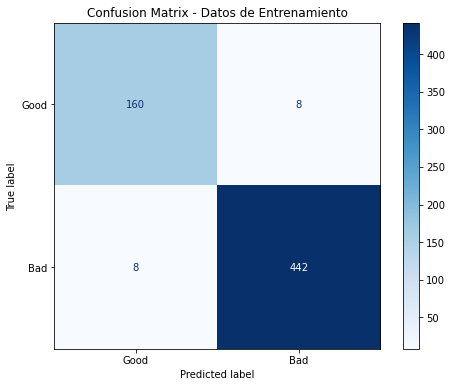

In [13]:
## Estadísticos de desempeño
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)
print('Train Acc:', accuracy_score(y_train, y_train_pred))
print('Train F1:', f1_score(y_train, y_train_pred))
print('Train ROC AUC:', roc_auc_score(y_train, y_train_proba[:, 1]))
## Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_train, y_train, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix - Datos de Entrenamiento')
plt.show()

### Evaluación en los datos de entrenamiento


test Acc: 0.9586466165413534
test F1: 0.9714285714285715
test ROC AUC: 0.9821019473081329


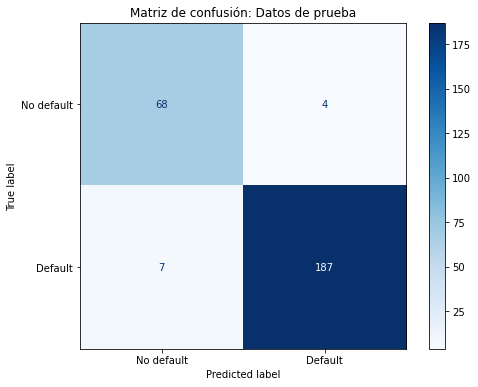

In [14]:
## Estadísticos de desempeño
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)
print('test Acc:', accuracy_score(y_test, y_test_pred))
print('test F1:', f1_score(y_test, y_test_pred))
print('test ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))

## Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['No default', 'Default'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Matriz de confusión: Datos de prueba')
plt.show()

In [15]:
y_pred = clf.predict(X2)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

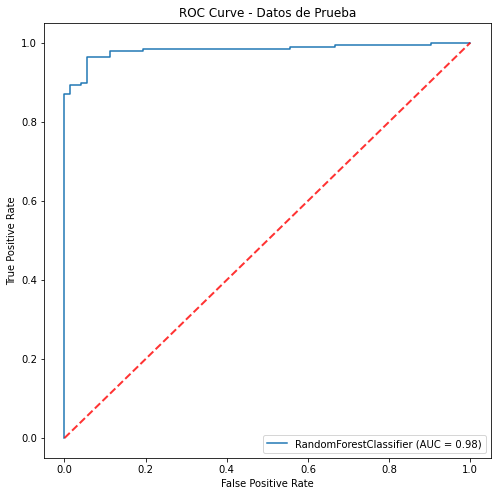

In [16]:
# ROC curve
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(clf, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.set_title('ROC Curve - Datos de Prueba')
plt.show()

Los resultados muestran un modelo con una capacidad predictiva abrumadora tanto en los datos de aprendizaje como en los de entrenamiento. Si bien es cierto, esto puede parecer que se trata de un modelo que ajusta perfectamente los datos, es de tomar en cuenta que estos datos son de muestra y, por lo tanto, el modelo probablemente no tendría un desempeño tan positivo en datos reales. Principalmente, el historial de deuda tiene vacios temporales, lo cual hace que una predicción sostenia en el tiempo sea discutible. Además, existe una carga fuerte hacia los defaults en los datos. La sensibilidad de la probabilidad de default es bastante alta conforme se da la primera ocurrencia, siendo esto esperado en un conjunto de datos pequeño.

### Importancia de los atributos

Como punto de validación final del modelo se presenta la relevancia de los atributos. En el caso de 

In [28]:
feature_names = num_cols.tolist() + col_trans.transformers_[1][1].get_feature_names().tolist()
df_importance = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
df_importance.sort_values('importance', ascending=False)

,feature,importance
3,diasven_mean,0.228643
5,tpagoc_mean,0.196288
4,dias_vencido_l1,0.095141
8,liquid_c_l1,0.071554
1,saldoi,0.057475
...,...,...
154,x1_1500176245,0.000000
153,x1_1500175943,0.000000
152,x1_1500175365,0.000000
151,x1_1500174661,0.000000


Estas cifras, aún considerando que se trata de datos de prueba, resaltan la importancia de las condiciones iniciales y del comportamiento histórico de las cuentas al recibir una nueva deuda. Aquellos que se encuentran en una situación desfavorable tienen menos incentivos a mejorarla y son más propensos a mantenerse en dicha situación. Ello denota que, desde un punto de vista financiero, realizar esfuerzos de colecturia justo antes del agravamiento de una nueva deuda puede ser efectivo en minimizar el impacto sobre la probabilidad de default toal. Además, psicológicamente, esto evidencia que puede ser favorable a recolección de montos de forma atomizada y separados del pool de deuda total, en lugar de cobros sobre saldos y deudas que puedan sonar graves.
